# Deep learning for timeseries. F.Chollet

A temperature forecasting example.  

Predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity

In [48]:
import numpy as np
import pandas as pd
from warnings import simplefilter
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import os, pathlib, shutil, random, urllib, zipfile

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(18, 9))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [14]:
url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
extract_dir = "."

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

In [15]:
jena = pd.read_csv('jena_climate_2009_2016.csv')
jena.to_parquet('jena_climate_2009_2016.parquet')
jena.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [16]:
jena['Date Time'] = pd.to_datetime(jena['Date Time'])
jena.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date Time        420451 non-null  datetime64[ns]
 1   p (mbar)         420451 non-null  float64       
 2   T (degC)         420451 non-null  float64       
 3   Tpot (K)         420451 non-null  float64       
 4   Tdew (degC)      420451 non-null  float64       
 5   rh (%)           420451 non-null  float64       
 6   VPmax (mbar)     420451 non-null  float64       
 7   VPact (mbar)     420451 non-null  float64       
 8   VPdef (mbar)     420451 non-null  float64       
 9   sh (g/kg)        420451 non-null  float64       
 10  H2OC (mmol/mol)  420451 non-null  float64       
 11  rho (g/m**3)     420451 non-null  float64       
 12  wv (m/s)         420451 non-null  float64       
 13  max. wv (m/s)    420451 non-null  float64       
 14  wd (deg)         420

In [17]:
jena.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

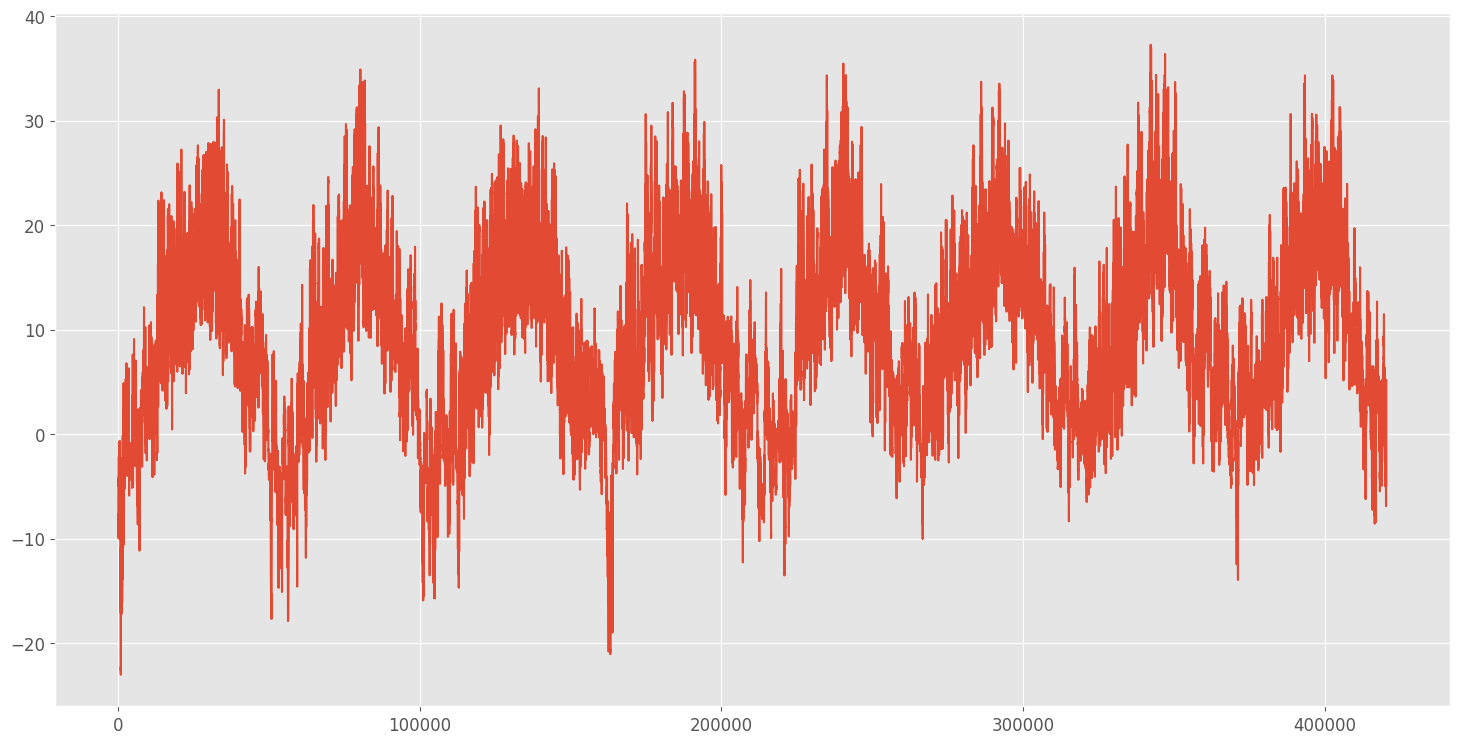

In [18]:
features = jena.loc[:,['p (mbar)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)']]
target = jena.loc[:,'T (degC)']

plt.plot(range(len(target)), target.values)
plt.grid(True)

# The stationality can be seen in this plot, also some extreme values

In [26]:
target.head()

0   -8.02
1   -8.41
2   -8.51
3   -8.31
4   -8.27
Name: T (degC), dtype: float64

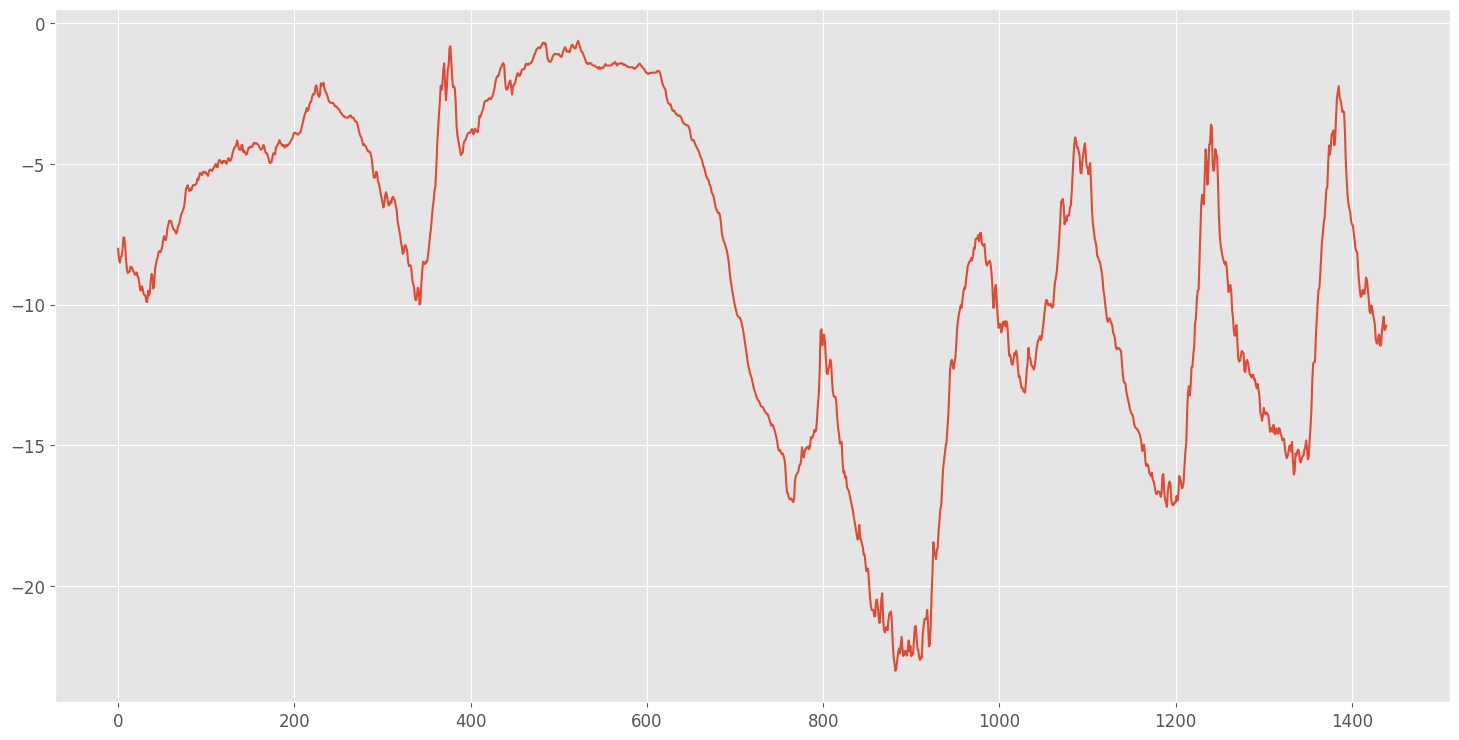

In [19]:
plt.plot(range(1440), target.values[:1440])
plt.grid(True)

## Seasonal and Trend Decomposition

In [20]:
6*24*365 # Lectures per year

52560

In [21]:
24*365

8760

<AxesSubplot: title={'center': 'Temperature Average ºC - 4 Years Moving Average'}>

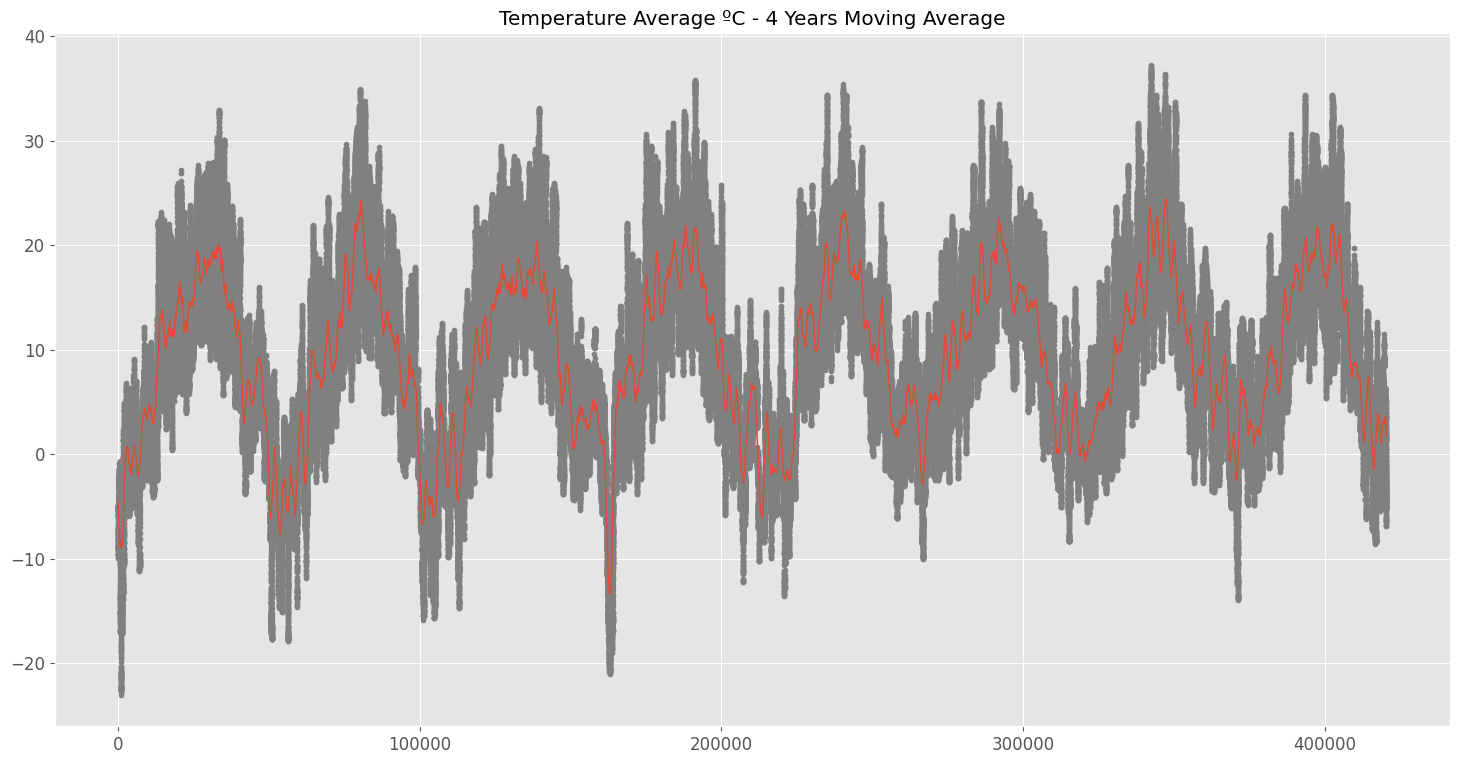

In [31]:
moving_average = target.rolling(
    window=365*4,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = target.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=1, title="Temperature Average ºC - 4 Years Moving Average", legend=False,
)

# 0. SEASONAL DECOMPOSE WITH STATSMODELS.TSA

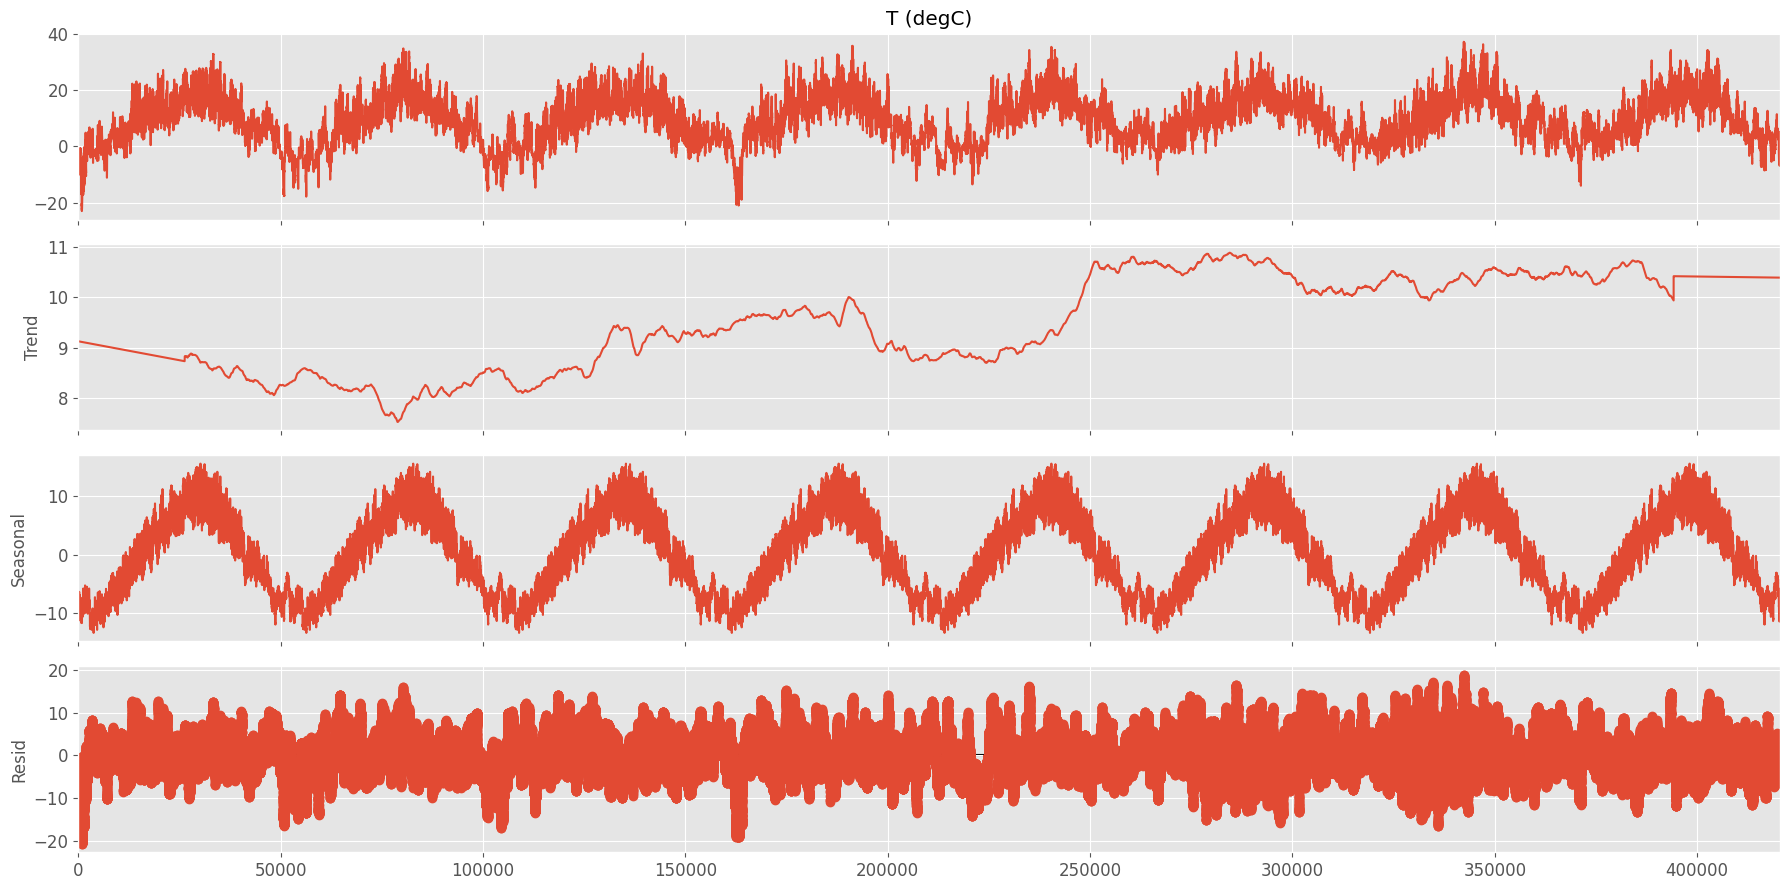

In [32]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(target, period = 52560, model= 'additive', extrapolate_trend='freq')
fig = res.plot()

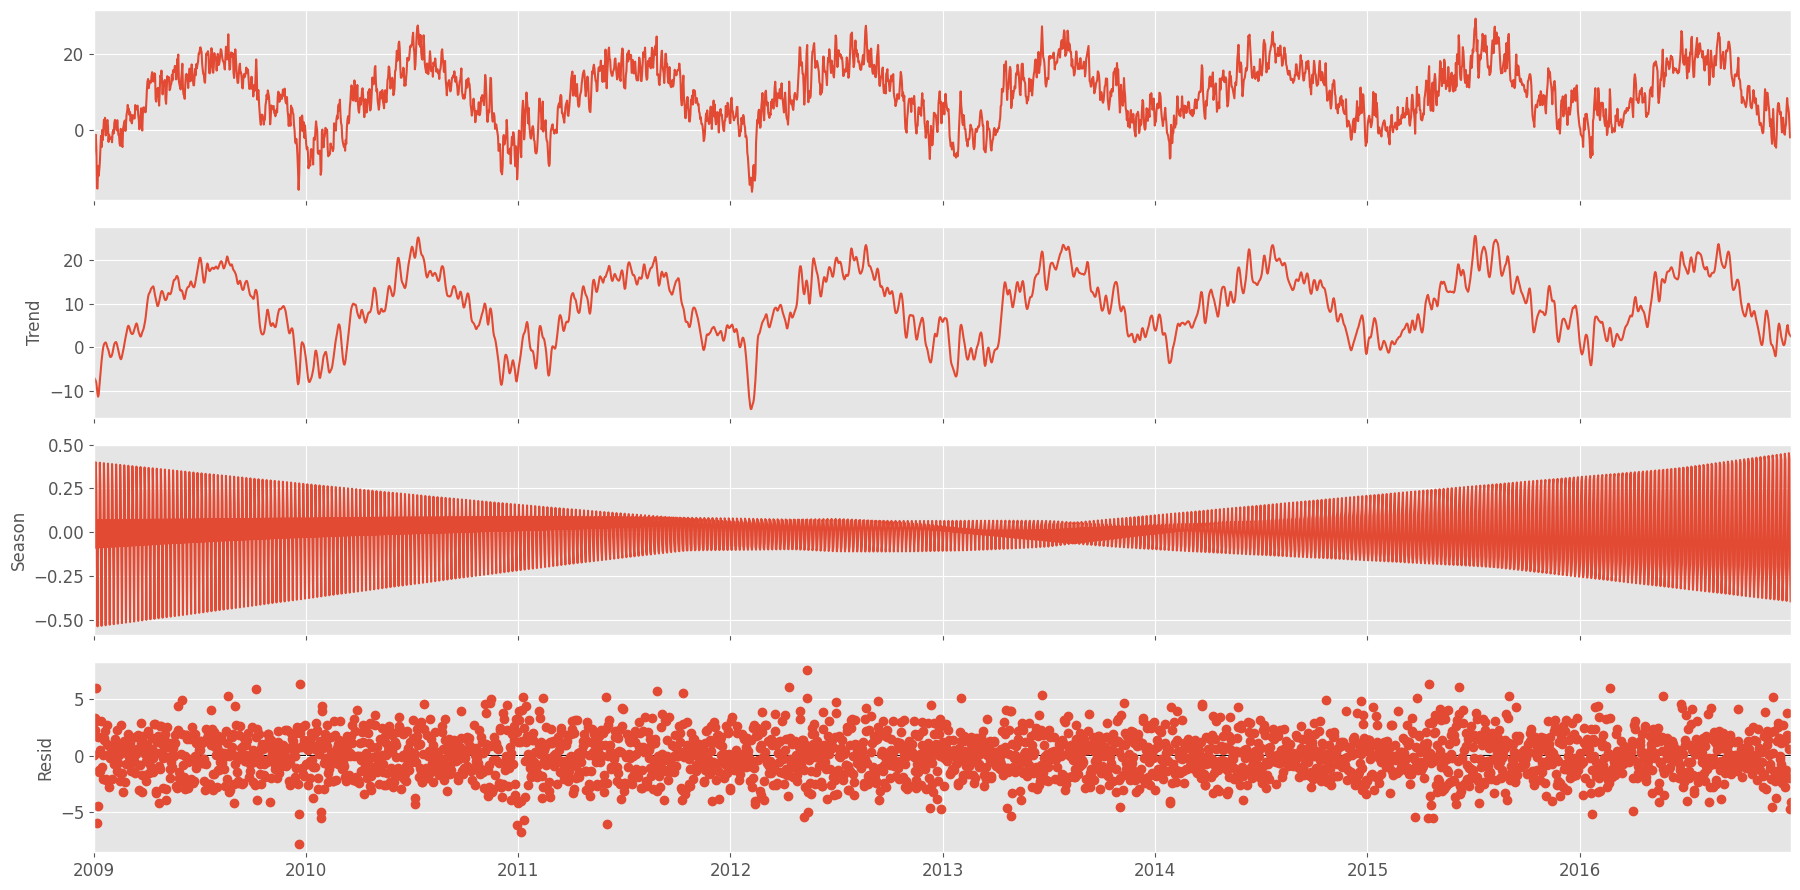

In [33]:
target_res = pd.Series(target.values, index=pd.date_range("1-1-2009", periods = len(target),freq='10min'))
target_res = target_res.resample('D').mean().ffill()

stl = STL(target_res, seasonal = 365)
res = stl.fit()
fig = res.plot()

# 1. A Linear Regression Forecasting Model. Pure Trend

From now on, however, we'll use a function from the statsmodels library called DeterministicProcess. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

In [23]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=target.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0


In [34]:
from sklearn.linear_model import LinearRegression

y = target  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [42]:
print('Model Intercept {}, Model Coeffs {}'.format(model.intercept_, model.coef_))

Model Intercept 0.0, Model Coeffs [7.84401340e+00 7.63251678e-06]


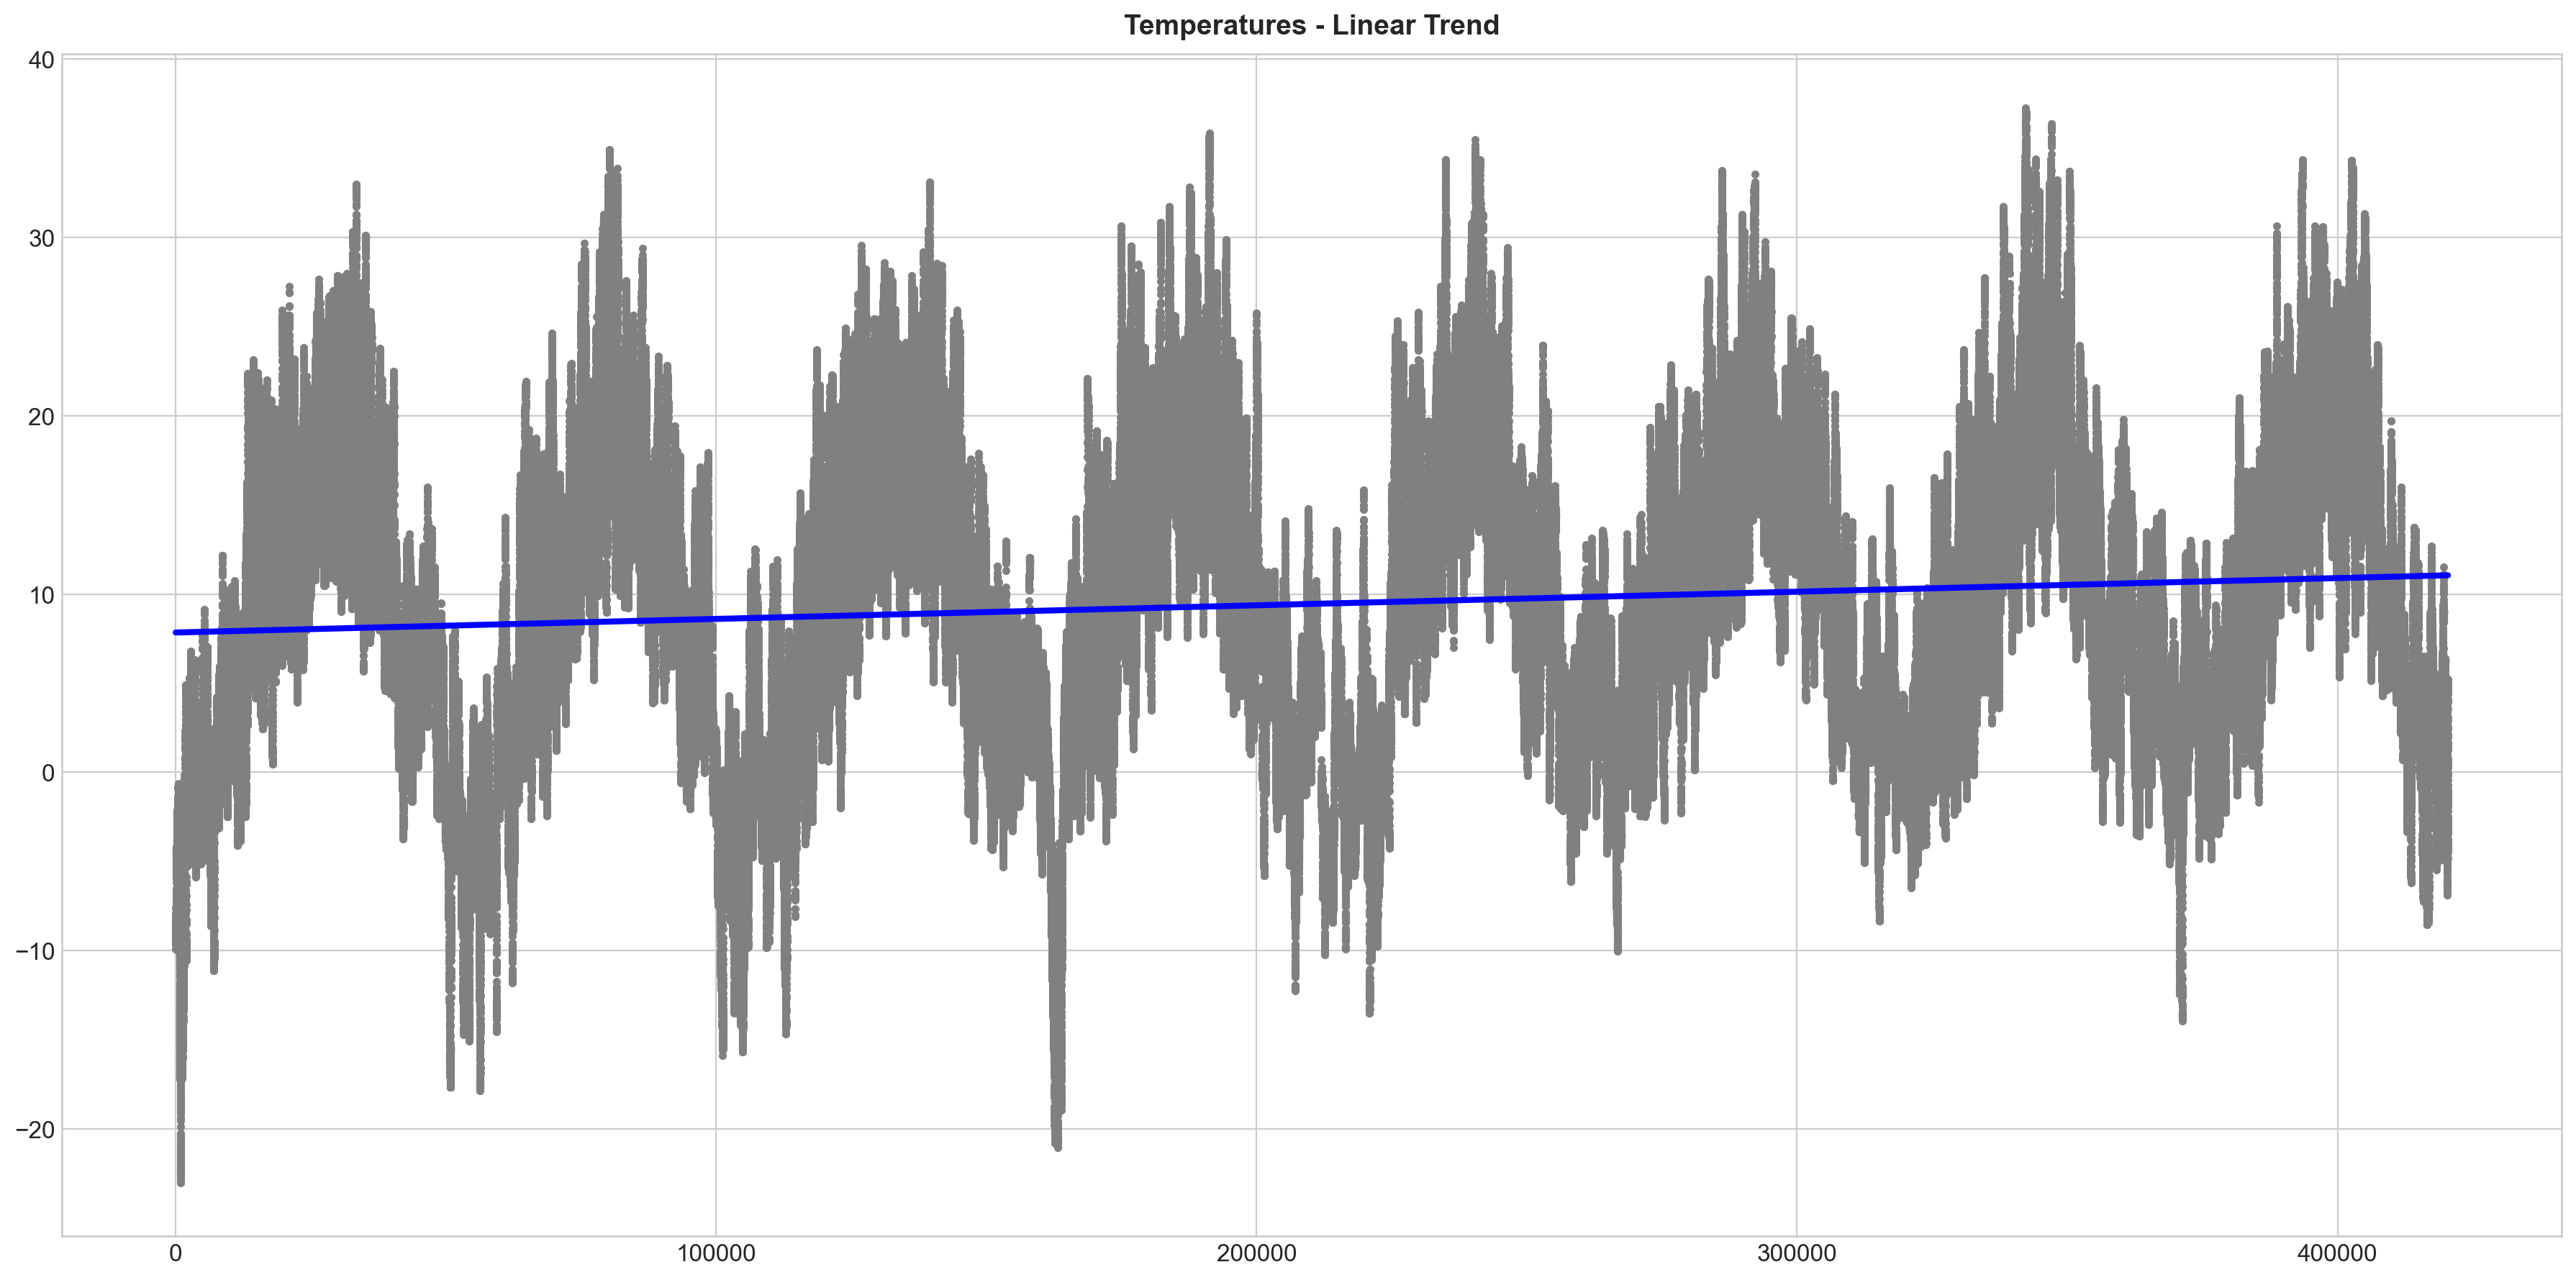

In [49]:
ax = target.plot(style=".", color="0.5", title="Temperatures - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, color = 'b', label="Trend")

In [56]:
# Forecasting with a Linear Model
X = dp.out_of_sample(steps=10000)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

420451    11.053120
420452    11.053128
420453    11.053136
420454    11.053143
420455    11.053151
dtype: float64

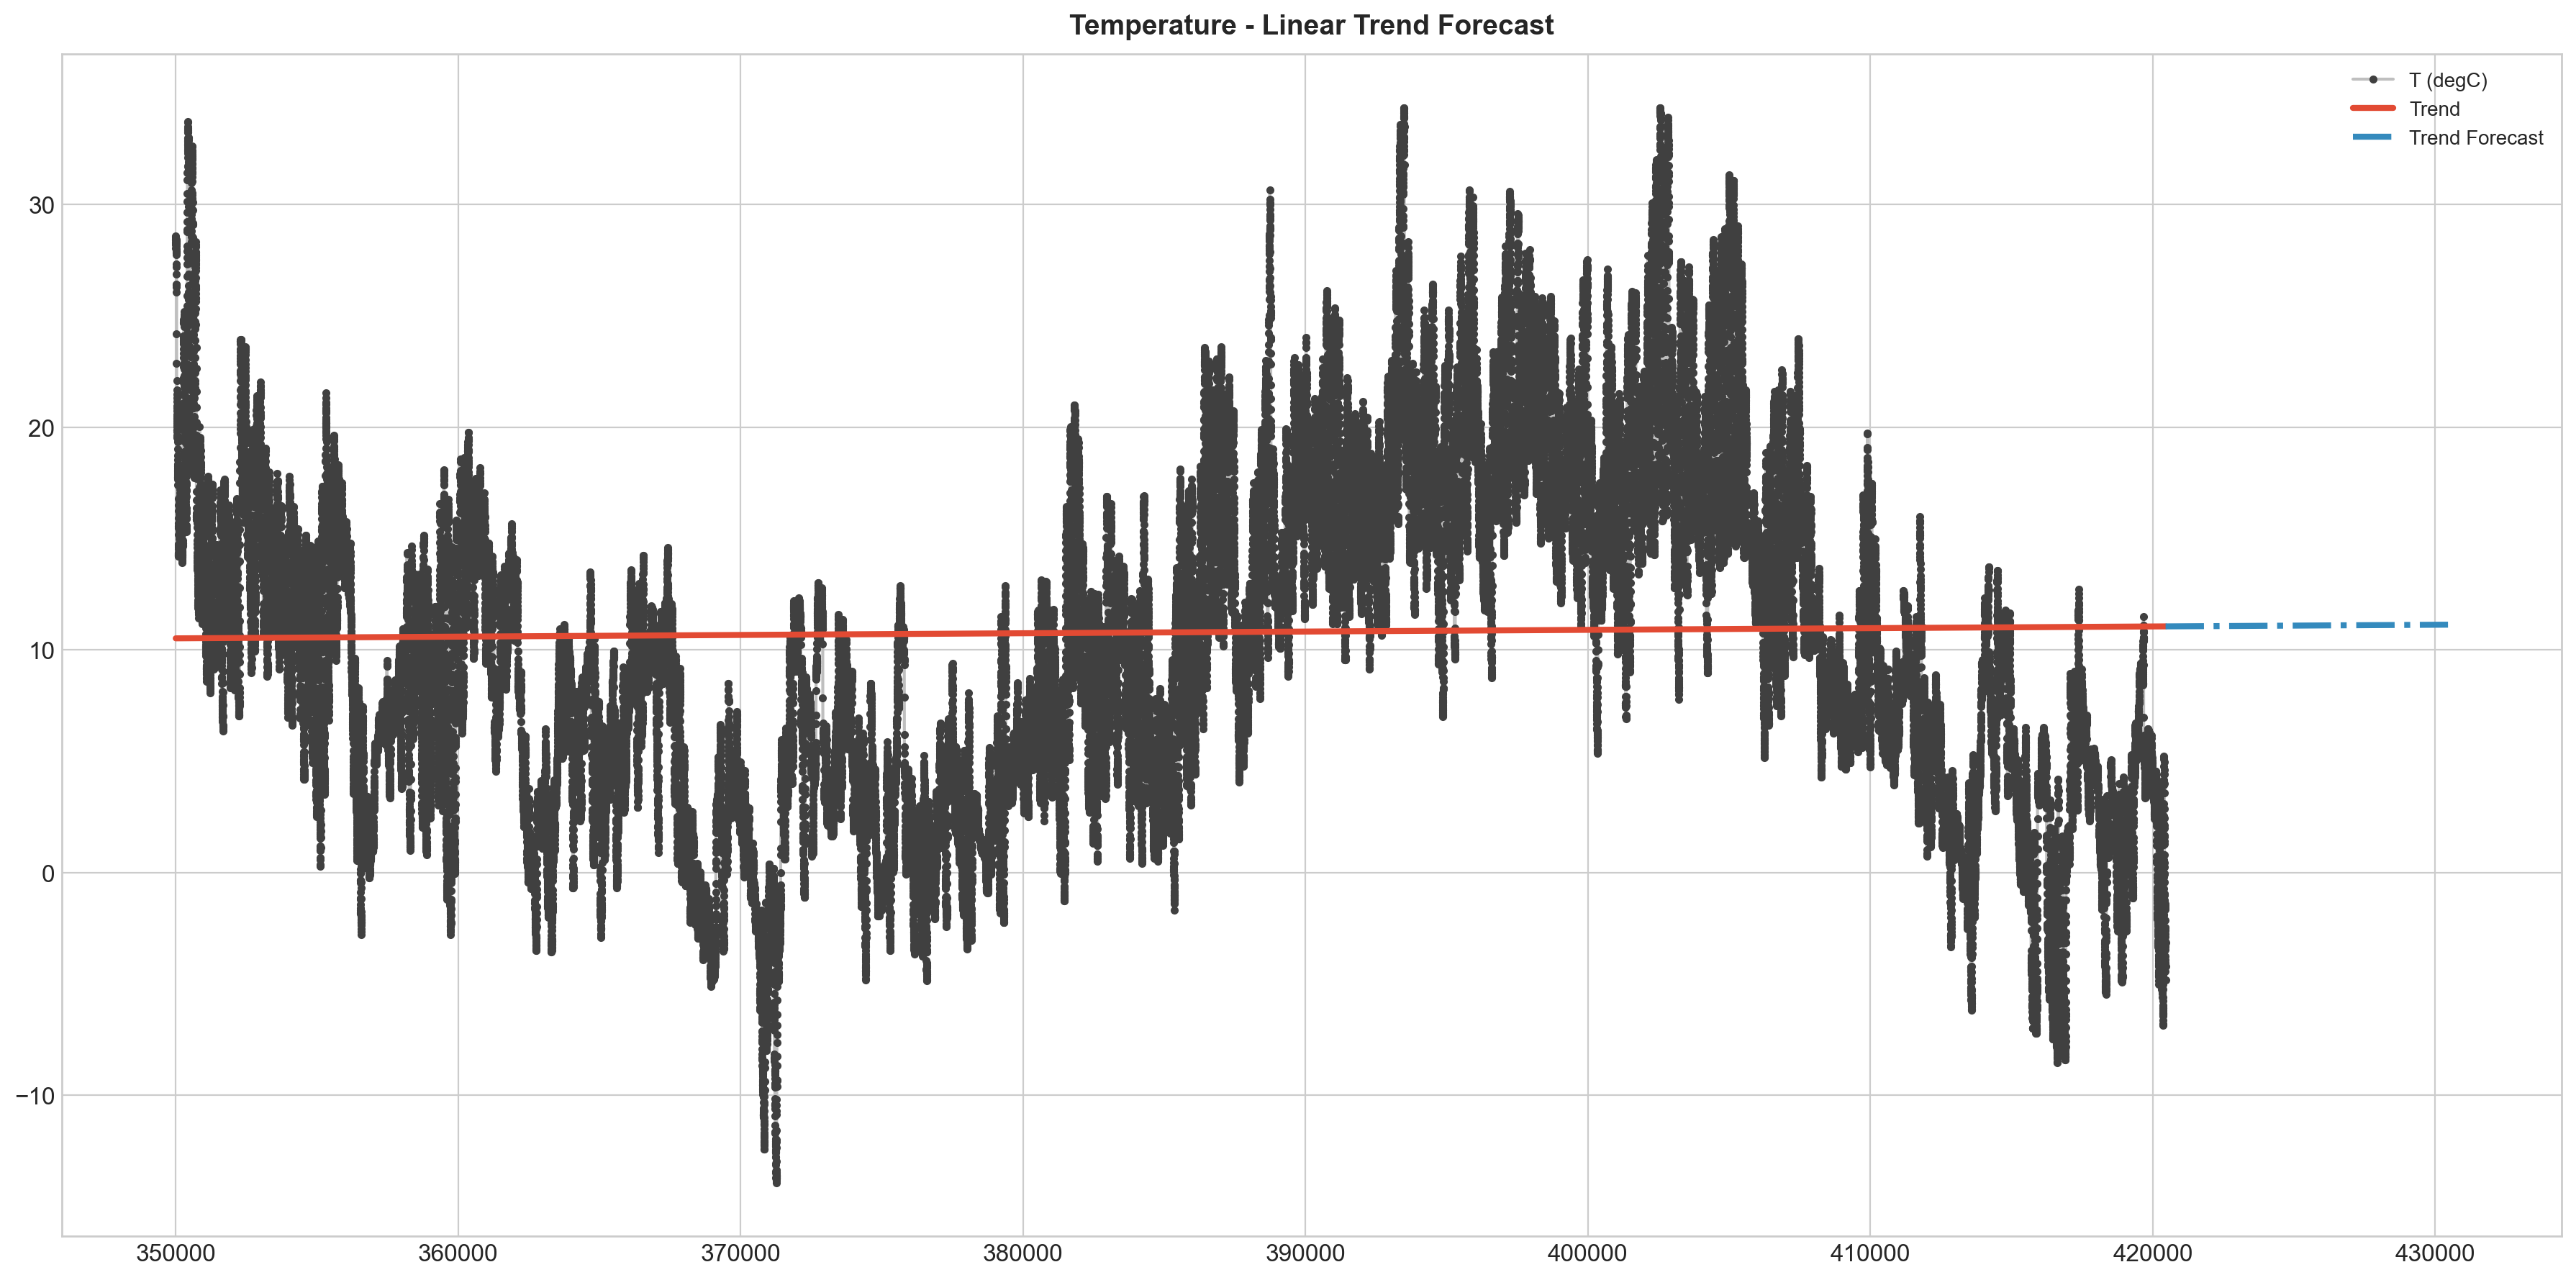

In [60]:
ax = target[350000:].plot(title="Temperature - Linear Trend Forecast", **plot_params)
ax = y_pred[350000:].plot(ax=ax, linewidth=3,ls='-', label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, ls= '-.', label="Trend Forecast", color="C1")
_ = ax.legend()